# Thermal Scattering



For this notebook, we will take a look at how thermal multiple scattering affects the spectra and the emission spectra of a hot jupiter. 

We have implemented the Toon scattering from PICASO (https://arxiv.org/pdf/1904.09355), see (https://natashabatalha.github.io/picaso_dev), into POSEIDON. 

For more details of the actual code, see emission_Toon() in emission.py in POSEIDON, and get_thermal_1d() in fluxes.py in PICASO.

In emission geometries where we are measuring light from a substellar object directly (i.e., secondary eclipse or direct emission), it is important to consider absorption, emission, and directional scattering. This is different than transmisssion, where any absorption or scattering process is assumed to contribute to the total extinction of a beam of photons. 

The observable emitted thermal emission from the top of the atmosphere originates from deeper, hotter atmospheric pressures than probed by transmission spectroscopy. 

As thermal emission photons propogate from deeper pressures, they interact with gas-phase molecular species by either being absorbed or causing the emission of more photons. 

Gas-phase species impart absorption features in an emission spectrum if the pressure-temperature profile has no thermal inversion (the temperature decreases with decreasing pressure/increasing altitude). Absorbed light is lost to the upwards propogating beam of photons. 

Gas-phase species will impart emission features in an emission spectrum if the pressure-temperature profile has a thermal inversion (the temperature increases with decreasing pressure/increasing altitude). Emitted light adds to the upward propogating beam of photons. 

Small gas particles can also interact with thermal emission via Rayeligh scattering. 

Rayeligh scattering is a symmetric process that equally scatters light in the forward and backwards direction. 

As thermal emission propogates up to escape a substellar object, Rayeligh scattering will scatter 50% of the light in the forward direction and 50% of it in the backward direction (you can think of forward scattering as a process that `helps' thermal emission escape the object. I always think of scattering as a pitcher that throws photons either forward or backwards). 

Mie scattering aerosols interact with thermal flux differently than gas-phase species. Aerosols interact with thermal flux by either scattering or absorbing light. When light is absorbed, it is lost to the upwards propagating beam. When light is scattered, aerosols can back-scatter and forward-scatter light asymmetrically.

This is in contrast to Rayeligh scattering that always scatters light symmetrically in the forward and backwards direction. The larger a Mie scattering particle is, the more likely it is to forward scatter radiation (more likely to `help' photons escape by throwing photons in the forward direction). The probability of an aerosol absorbing or scattering, and the probability of an aerosol forward or back scattering a photon, are dictated by the single scattering albedo (ω) and asymmetry parameter (g), as we will see below. Also as we will see below, the scattering properties of aerosols can introduce 'scattering' features into an emission spectrum, even if the temperature-pressure profile is isothermal. 

Given that scattering gas particles and aerosols have a probability to forward scatter and back scatter, you can imagine that backscattered photons might be backscattered again and therefore put back in the upwards propogating beam. This is called multiple scattering. 

Reflection is a form of multiple scattering where light from a star is back-scattered by Rayeligh and Mie scattering by a substellar object's atmosphere. We will explore this form of multiple scattering more in the Reflection retrieval. 

<img src="../../_static/notebook_images/Emission-cloud-effect.png" />

## Hot Jupiter Scattering

In emission geometries, aerosols can impart scattering features even if the atmosphere is isothermal. 

We will be using HD 189733 b (a hot Jupiter) as an example of this.

In [2]:
from POSEIDON.constants import R_Sun, R_J, M_J
from POSEIDON.core import create_star, create_planet, define_model, \
                          wl_grid_constant_R, read_opacities

import numpy as np
from scipy.constants import au
from scipy.constants import parsec as pc

#***** Model wavelength grid *****#

wl_min = 0.5      # Minimum wavelength (um)
wl_max = 20       # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define planet properties *****#

planet_name = 'HD 189733b'  # Planet name used for plots, output files etc.

R_p = 1.13*R_J    # Planetary radius (m)
M_p = 1.129*M_J
d = 19.7638*pc
a_p = 0.03142*au

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, a_p = a_p)

In [3]:
#***** Define stellar properties *****#

R_s = 0.78*R_Sun      # Stellar radius (m)
T_s = 5014         # Stellar effective temperature (K)
Met_s = 0.13          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.58       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

Lets create two models, one with thermal scattering turned on and one with thermal scattering turned off. 

In order to turn in scattering, we just set `scattering = True' in our define_model() function

We will also include enstatite (MgSiO3) Mie clouds from the precomputed aerosol database. The aerosol database includes the asymmetry parameter and single scattering albedo, which are utilized to determine the scattering/absoring properties of Mie scattering aerosols. 

We will explore what the asymmetry parameter and single scattering alebdo are later in this notebook

In [4]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['MgSiO3'] # <---- Lets include enstatite (MgSiO3) aerosols 

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                     PT_profile = 'isotherm',
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with direcitonal scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering


Reading in database for aerosol cross sections...


In [5]:
#***** Define model *****#

model_name_no_scattering = 'No Thermal Multiple Scattering'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['MgSiO3'] # <---- Lets include enstatite (MgSiO3) aerosols 

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                    PT_profile = 'isotherm',
                    cloud_model = 'Mie',cloud_type = 'slab',
                    aerosol_species = aerosol_species,
                    scattering = False) # <---- Set scattering = False for scattering processes to be considered 100% extinctive 

Reading in database for aerosol cross sections...


Lets take a quick preview of the optical proeprties of MgSiO3 with this helper function

MgSiO3
Reading in database for aerosol cross sections...
Loading in :  ../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/MgSiO3.txt
Loading in :  ../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/MgSiO3.txt


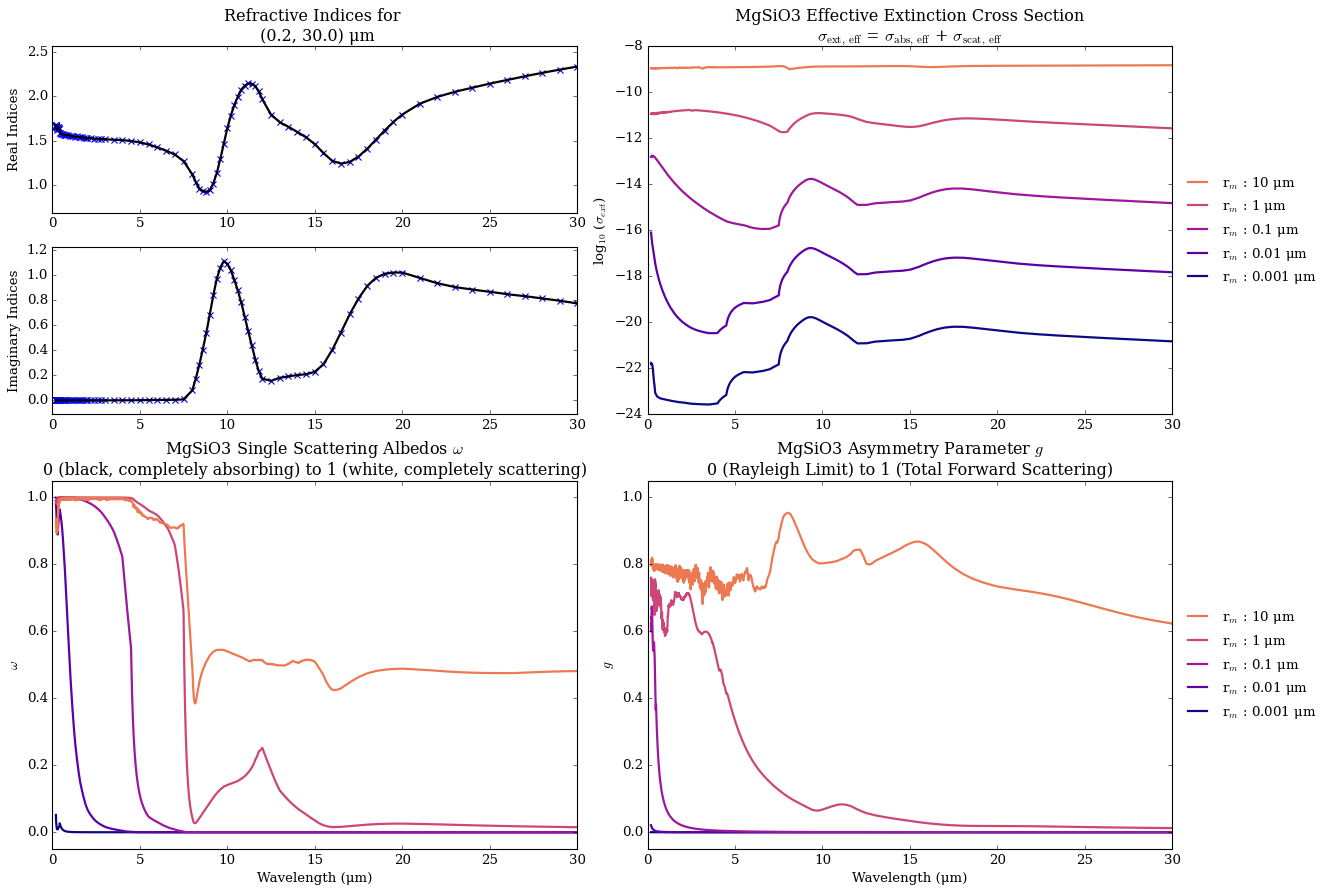

In [128]:
from POSEIDON.clouds import database_properties_plot

# All the refractive index txt files with names corresponding to their name in supported_species.py are
# found in /refractive_indices_txt_files/File_names_corrsponding_to_name_in_supported_species/

file_name = '../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/MgSiO3.txt'

database_properties_plot(file_name)

In [19]:
#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 100    # Same as prior range for T
T_fine_max = 3100    # Same as prior range for T
T_fine_step = 20     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

#***** Specify fixed atmospheric settings for retrieval *****#

# Atmospheric pressure grid
P_min = 1.0e-6   # 10 nbar
P_max = 100       # 10 bar
N_layers = 100   # 100 layers

# Let's space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure
P_ref = 1   # Retrieved R_p_ref parameter will be the radius at 10 bar

#***** Run atmospheric retrieval *****#
opac = read_opacities(model_scattering, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
CO2-H2 done
CO2-CO2 done
CO done
CO2 done
H2O done
Opacity pre-interpolation complete.


Lets make an isothermal atmosphere at the equilibrium temperature of HD 189733 b (1200K) with an enstatite slab that ranges from 100 to 0.1 bars. 

We will pick large particles (1 um sized), since larger aerosols have stronger scattering properties

In [7]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T                     =   1200 # <---- Equilibrium temperature of HD 1897333 b 

log_CO                =   -5.30 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -3.07 # <---- Note that gas-phase species have no features in isothermal atmospheres in emission
log_H2O               =   -5.33  

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere= make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) # <---- We can use the same atmosphere object for both models

Lets also make an atmosphere with no gas-phase species in it

In [8]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T                     =   1200 # <---- Equilibrium temperature of HD 1897333 b 

log_CO                =   -100 # <---- -100 is a proxy for no gas-phase species
log_CO2               =   -100 
log_H2O               =   -100  

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere_no_gas_phase = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) # <---- We can use the same atmosphere object for both models

Lets take a look at the PT, chemical, and cloud profiles for our model atmosphere

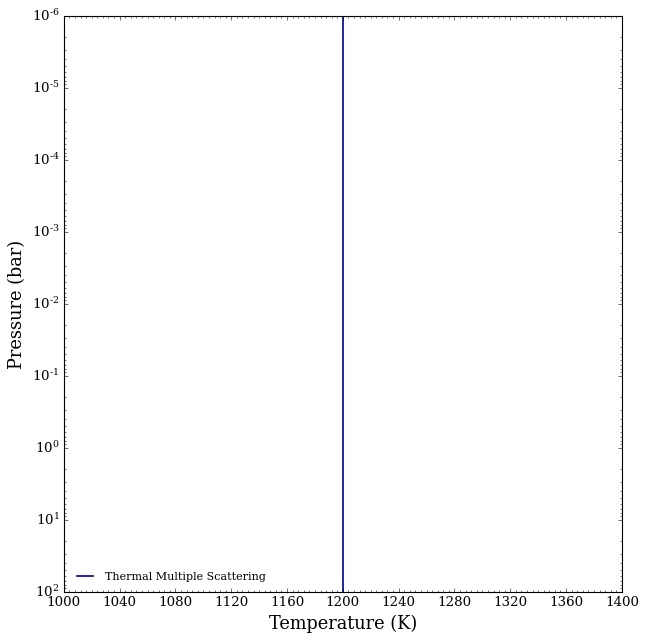

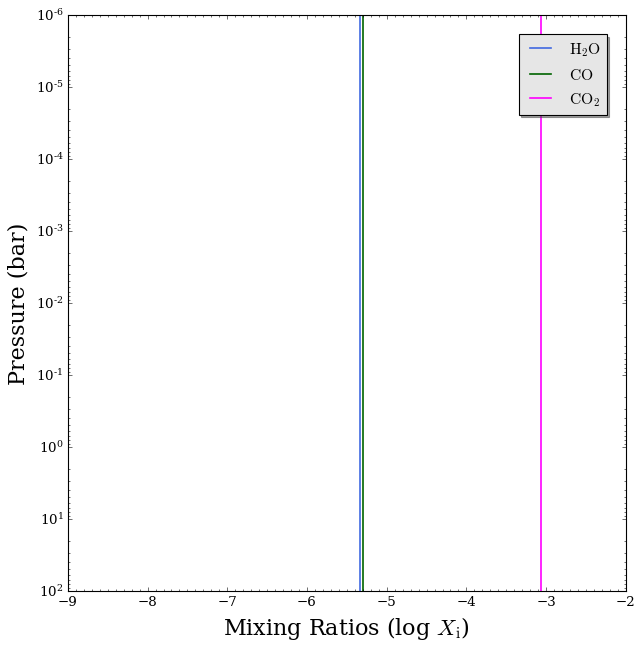

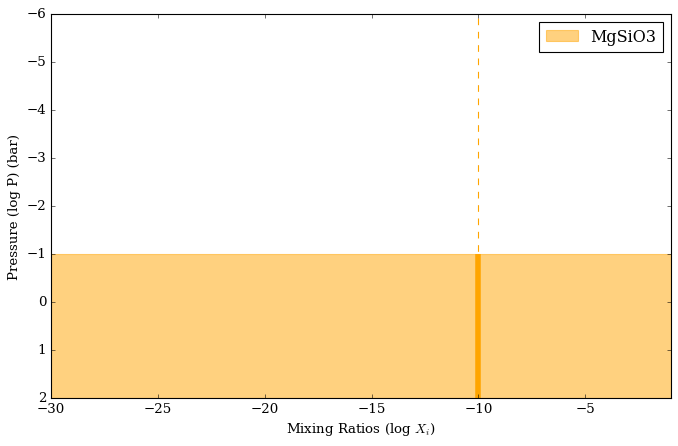

In [9]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere)


fig_chem = plot_chem(planet, model_scattering, atmosphere, 
                     plot_species = ['H2O', 'CO', 'CO2'],
                     log_X_min = -9, log_P_max = 2.0)


from POSEIDON.clouds import plot_clouds

plot_clouds(planet,model_scattering,atmosphere)

Lets generate the secondary-eclipse spectra and plot it up!

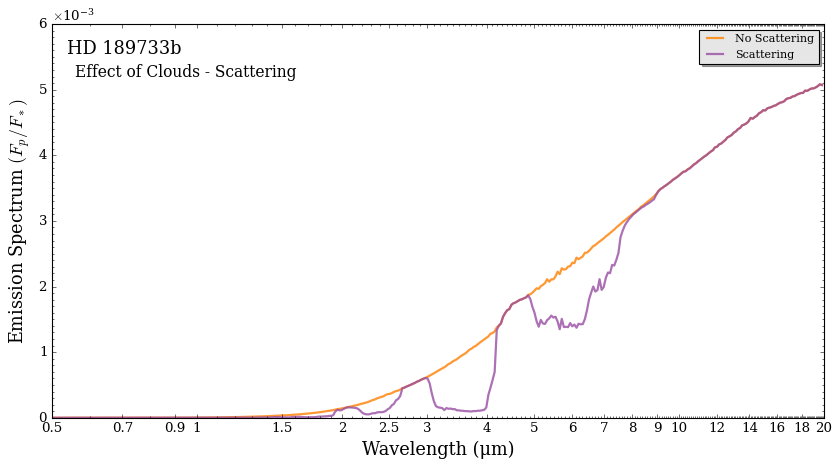

In [10]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission', save_spectrum = True) # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                           spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['No Scattering', 'Scattering'], # <---- Remember to set y_unit!
                        legend_location = 'upper right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

Woah! Those are some big features.

As we can see above, even in isothermal environments, aerosols can impart scattering features that will cause the spectrum to deviate from a blackbody.

Lets see how it looks like with no gas-phase species

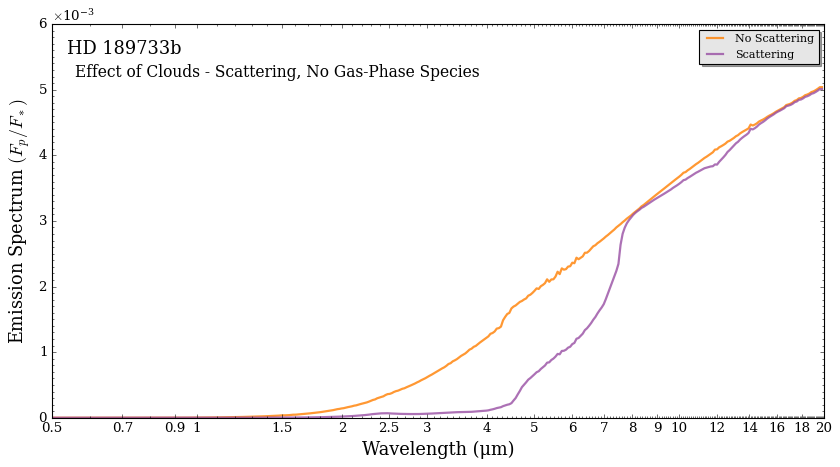

In [12]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere_no_gas_phase, opac, wl,  # <---- New atmosphere object
                              spectrum_type = 'emission', save_spectrum = True) # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere_no_gas_phase, opac, wl, 
                           spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering, No Gas-Phase Species'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['No Scattering', 'Scattering'], # <---- Remember to set y_unit!
                        legend_location = 'upper right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

Without gas-phase species, the enstatite slab is causing a general decrease in flux across the spectrum. 

An eagle-eyed user would notice that the spectrum with gas-phase species included has 'features' in the scattering model where the gas-phase absorption features are (4-5 microns is the CO2 and CO combined feature). In an isothermal atmosphere, these gas species are acting as scatterers and putting photons back into the beam via multiple scattering.

Lets explore whats causing the decrease in flux due to scattering by looking at enstatite's (1 um sized) effective extinction coefficient, single scattering albedo, and asymmetry paremeter.

We will pull these properties directly from the precomputed aerosol database.

In [18]:
from POSEIDON.clouds import load_aerosol_grid, interpolate_sigma_Mie_grid
import matplotlib.pyplot as plt 

species = 'MgSiO3'

# Load in the grid 
aerosol_grid = load_aerosol_grid([species])

# Set the particle size to 1 um 
r_m = 1

# This funfction loads in the grid 
sigma_Mie_interp_array = interpolate_sigma_Mie_grid(aerosol_grid, wl, [r_m], [species],)

# Lets load in the cross sections, asymmetry parameter, and single scattering albedo 
eff_ext = sigma_Mie_interp_array[species]['eff_ext']
eff_w = sigma_Mie_interp_array[species]['eff_w']
eff_g = sigma_Mie_interp_array[species]['eff_g']

Reading in database for aerosol cross sections...


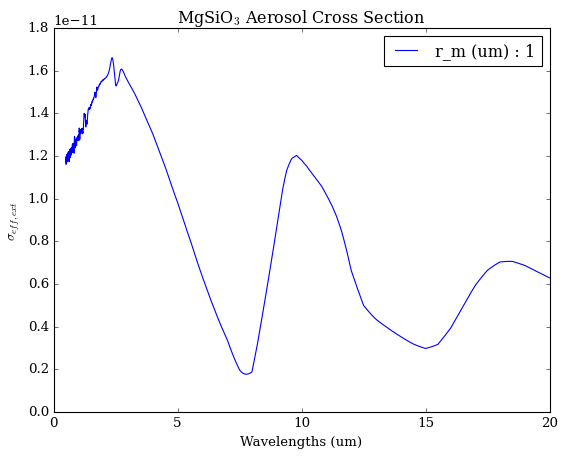

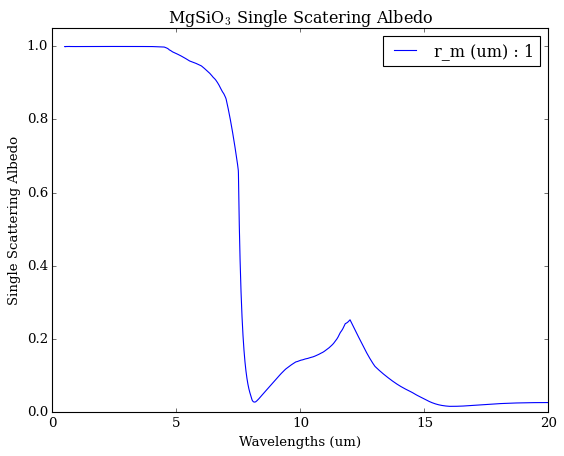

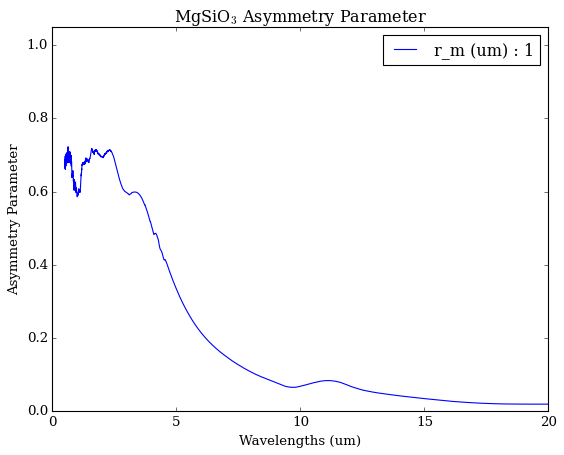

In [19]:
# Plotting

label = 'r_m (um) : ' + str(r_m)
title = 'MgSiO$_3$ Aerosol Cross Section'

plt.plot(wl,eff_ext, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('$\sigma_{eff,ext}$')
plt.show()

title = 'MgSiO$_3$ Single Scatering Albedo'

plt.plot(wl,eff_w, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Single Scattering Albedo')
plt.ylim((0,1.05))
plt.show()

title = 'MgSiO$_3$ Asymmetry Parameter'

plt.plot(wl,eff_g, label = label)
plt.legend()
plt.title(title)
plt.xlabel('Wavelengths (um)')
plt.ylabel('Asymmetry Parameter')
plt.ylim((0,1.05))
plt.show()

The effective extinction cross section is the combined scattering and absorption cross section. The scattering function disentangles the scattering and absorption properties by using the single scattering albedo and asymmetry parameter. 

The single scattering albedo defines the probaility of a particle absorbing or scattering a photon. A single scattering albedo of 0 means that 100% of photons will be absorbed whereas a single scattering albedo of 1 means that 100% of photons will be scattered. 

The asymmetry parameter defines the probability of a particle forward scattering or back scattering a photon. An asymmetry parameter of 0 means that 50% of particles will be forward scattered (the Rayleigh limit), and an asymmetry parameter of 1 means that 100% of particles will be forward scattered. 

The decrease in flux in the spectrum due to scattering is a complex interplay between gas-phase and aerosol scattering and multiple scattering that is determined by these parameters. To see an example of a strong forward scattering atmosphere that increases flux, see a 'Y-Dwarf with Scattering Clouds' tutorial notebook.

### Sub-Micron Aerosols in a Non-isothermal Atmosphere Without Thermal Inversions

Lets look at sub-micron aerosol absorption in a atmosphere with a non-isothermal pressure-temperature profile without thermal inversions. 

Sub-micron aerosols are less prone to imparting 'scattering' features, and will instead impart absorption and emission features much like the gas-phase (this is because Mie-scattering occurs when the wavelength of light is on par with the particle size. In the previous case we use 1 um sized particles and looked at scattering features in the 1-10 micron range. In this case, we are looking at sub-micron sized particles which means that the absorptions feature will dominate over the Mie scattering ones).

We will use a new aerosol species, Mg2SiO4_crystalline, which has sharp features and the new Guillot dayside profile.

Since the temperature decreases with height, we expect both the gas and aerosol species to impart absorption features in the atmosphere. 

In [108]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering - Non Isothermal'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['Mg2SiO4_crystalline'] # <---- Lets include crystalline forsterite (Mg2SiO4) crystals, which have sharp features at 10 um

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside',                 # <---- Lets use the new Guillot_dayside PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with direcitonal scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering

model_name_no_scattering = 'No Thermal Multiple Scattering - Non Isothermal'

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                     PT_profile = 'Guillot_dayside',                 # <---- Lets use the new Guillot_dayside PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with direcitonal scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering


Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


Lets preview the optical properties of crystalline Mg2SiO4. From below, it looks like sub-micron sized particles have three sharp features from 10-13 um. 

Mg2SiO4_crystalline
Reading in database for aerosol cross sections...
Loading in :  ../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/Mg2SiO4_crystalline.txt
Loading in :  ../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/Mg2SiO4_crystalline.txt


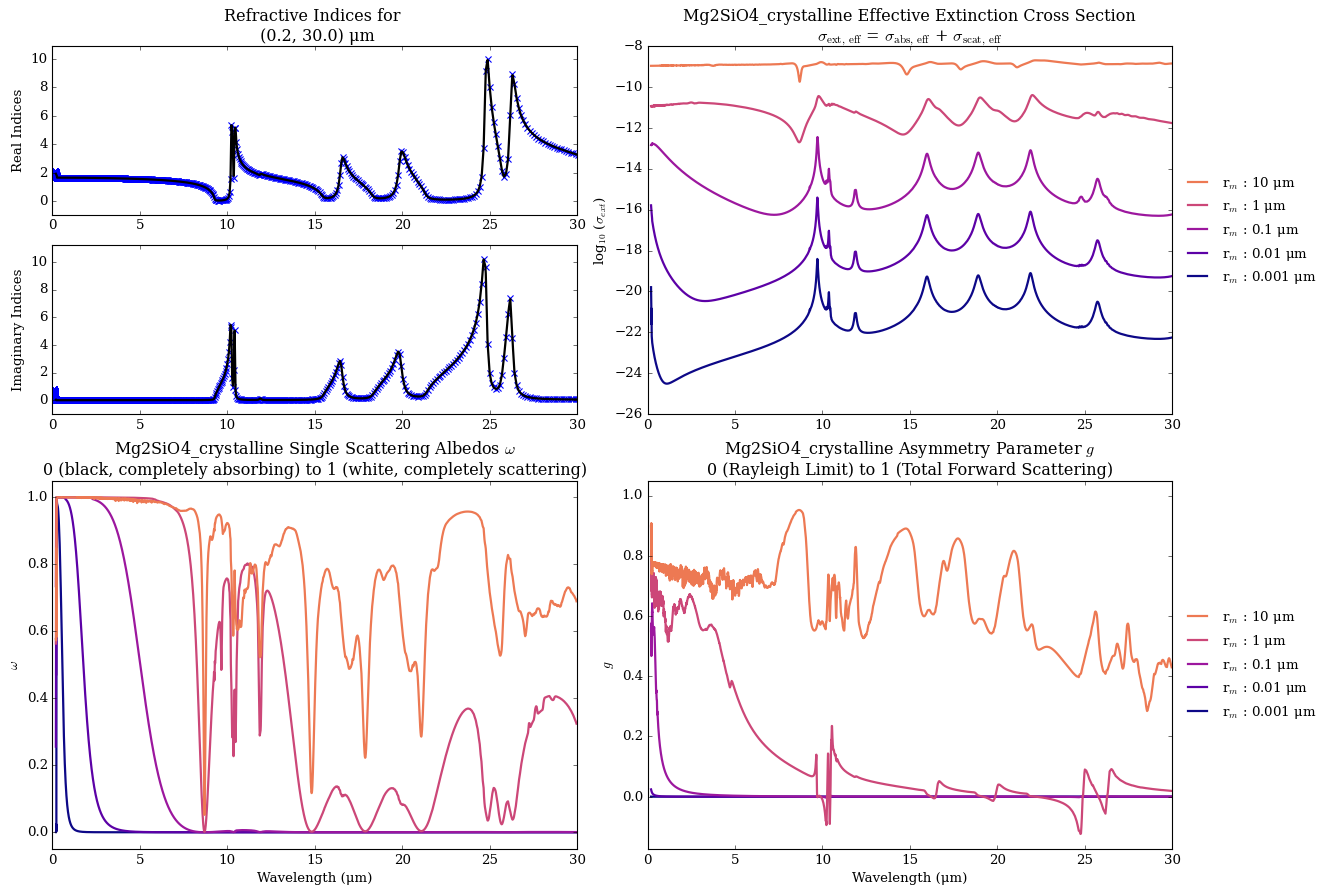

In [126]:
from POSEIDON.clouds import database_properties_plot

# All the refractive index txt files with names corresponding to their name in supported_species.py are
# found in /refractive_indices_txt_files/File_names_corrsponding_to_name_in_supported_species/

file_name = '../../../../refractive_indices_txt_files/File_names_corresponding_to_name_in_supported_species/Mg2SiO4_crystalline.txt'

database_properties_plot(file_name)

In [112]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

log_kappa_IR          =   -4   # <---- IR opacity 
log_gamma             =   -0.4 # <---- Ratio between IR and optical opacity 
T_int                 =   600  # <---- Internal temperature 
T_equ                 =   1200 # <---- Equilibrium temperature 

log_CO                =   -5 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -5  
log_H2O               =   -5 # <---- Water gas has a strong cross section in the mid-infrared that will 'cover' aerosol features, so we set it low

log_P_top_slab_MgSiO3 =   -6    # We will make the aerosols span the entire atmosphere
Delta_log_P_MgSiO3    =   8     
log_r_m_MgSiO3        =   -2    # <---- Sub-Micron sized particles have less scattering features
log_X_MgSiO3          =   -13   # <---- Modest uniform mixing ratio

PT_params = np.array([log_kappa_IR, log_gamma, T_int, T_equ])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) 

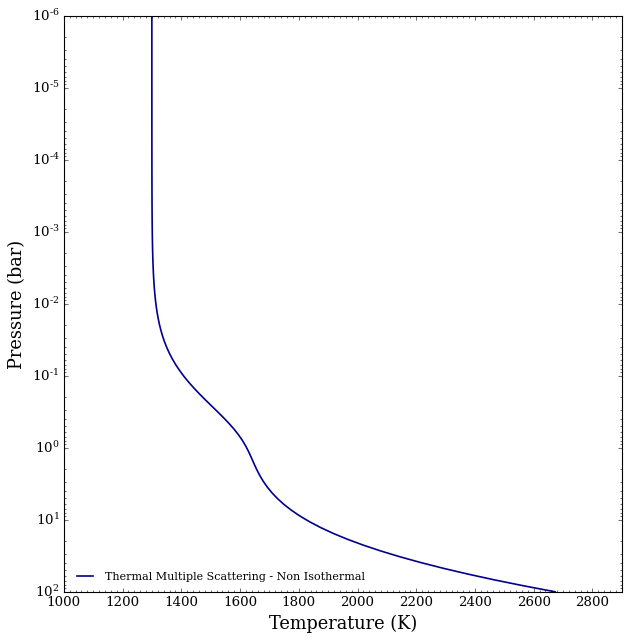

In [78]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere)

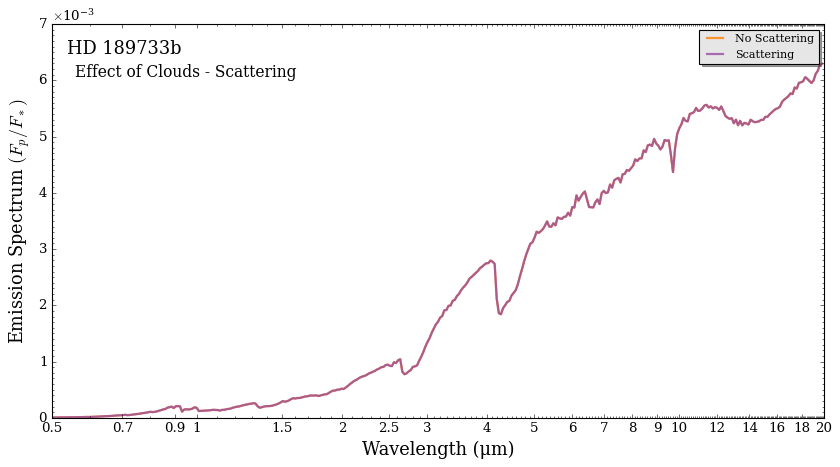

In [113]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission', save_spectrum = True) # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                           spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['No Scattering', 'Scattering'], # <---- Remember to set y_unit!
                        legend_location = 'upper right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

As we except, both the gas phase and aerosols impart absorption features. Notably, CO2 has a large absorption feature between 4-5 um and the forsterite particles impart a spiky feature at 10 um. Since the aerosols are sub-micron, scattering has less of an effect!

### Impact of a thermal inversion

Now lets see what happens when we include a thermal inversion (temperature increases with height). In this case, we except the absorption features from before to flip and become emission features.

We will keep the same aerosol species, but switch to the gradient PT profile, which allows us to define a steep thermal inversion

In [114]:
#***** Define model *****#

model_name_scattering = 'Thermal Multiple Scattering - Non Isothermal'

bulk_species = ['H2', 'He']
param_species = ['CO', 'CO2','H2O',]
aerosol_species = ['Mg2SiO4_crystalline'] # <---- Lets include crystalline forsterite (Mg2SiO4) crystals, which have sharp features

# Create the model object
model_scattering = define_model(model_name_scattering, bulk_species, param_species, 
                     PT_profile = 'gradient',                 # <---- Lets use a gradient PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with direcitonal scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering

model_name_no_scattering = 'No Thermal Multiple Scattering - Non Isothermal'

model_no_scattering = define_model(model_name_no_scattering, bulk_species, param_species, 
                     PT_profile = 'gradient',                 # <---- Lets use a gradient PT profile
                     cloud_model = 'Mie',cloud_type = 'slab', # <---- Mie clouds come with direcitonal scattering
                     aerosol_species = aerosol_species,
                     scattering = True)                       # <---- Set scattering = True for thermal multiple scattering


Reading in database for aerosol cross sections...
Reading in database for aerosol cross sections...


In [123]:
from POSEIDON.core import make_atmosphere

R_p_ref               =   1.12 * R_J

T_high = 1500
T_low = 1200

log_CO                =   -5 # <---- Some proxy gas-phase mixing ratios
log_CO2               =   -5 # <---- Note that gas-phase species have no features in isothermal atmospheres in emission
log_H2O               =   -5

log_P_top_slab_MgSiO3 =   -1    # <---- Top of the slab is at 0.1 bars
Delta_log_P_MgSiO3    =   3     # <---- Slab extends down to 100 bars
log_r_m_MgSiO3        =   0     # <---- Large particles (1 um) have stronger scattering properties 
log_X_MgSiO3          =   -10   # <---- Modest mixing ratio of enstatite in the slab

PT_params = np.array([T_high, T_low])

log_X_params = np.array([log_CO, log_CO2,log_H2O])

cloud_params = np.array([log_P_top_slab_MgSiO3, Delta_log_P_MgSiO3, log_r_m_MgSiO3, log_X_MgSiO3])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model_scattering, P, P_ref, R_p_ref, 
                             PT_params, log_X_params, cloud_params) 

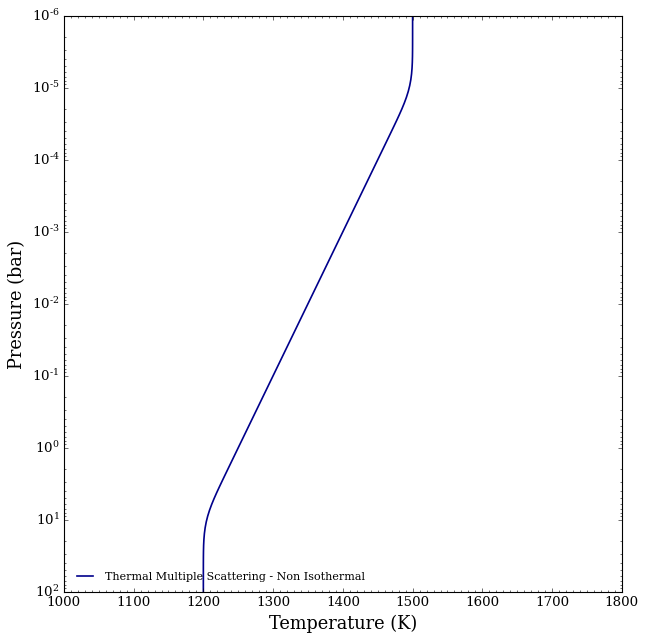

In [125]:
from POSEIDON.visuals import plot_PT

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model_scattering, atmosphere)

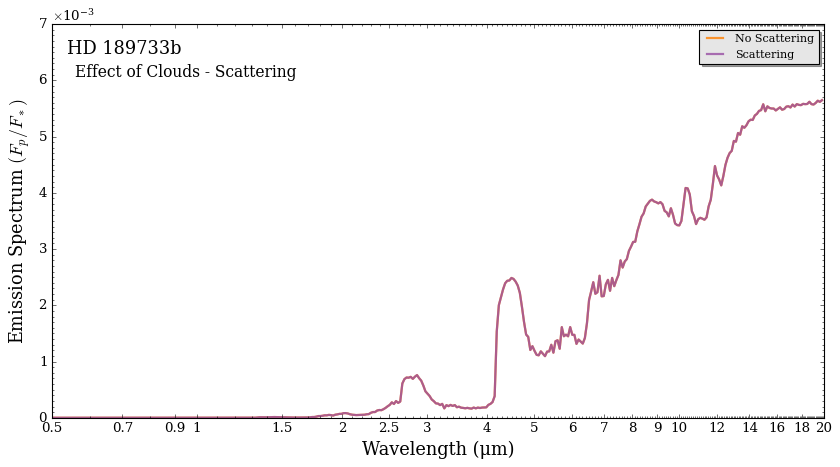

In [124]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate eclipse spectra
Fp_Fs_no_scat = compute_spectrum(planet, star, model_no_scattering, atmosphere, opac, wl, 
                              spectrum_type = 'emission', save_spectrum = True) # <---- Remember to set spectrum_type = 'emission'!

Fp_Fs_scat = compute_spectrum(planet, star, model_scattering, atmosphere, opac, wl, 
                           spectrum_type = 'emission', save_spectrum = True)

spectra = []   
spectra = plot_collection(Fp_Fs_no_scat, wl, collection = spectra)
spectra = plot_collection(Fp_Fs_scat, wl, collection = spectra)

title = 'Effect of Clouds - Scattering'

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 100, plot_full_res = False,
                        y_unit = 'eclipse_depth', spectra_labels = ['No Scattering', 'Scattering'], # <---- Remember to set y_unit!
                        legend_location = 'upper right', wl_axis = 'log', colour_list = ['#ff7f00', '#984ea3'],
                        plt_label = title,
                        figure_shape = 'wide')

As we expect, all absorption features have become emission features! 

# 